In [1]:
import Pkg; Pkg.activate("C:/Users/s151781/AppData/Local/Julia-1.3.1/GN/Project.toml")
using Revise
using Distributions
using PyPlot
using FFTW
using Compat
using WAV
using DSP
using Base64
using ForneyLab
using LinearAlgebra
using ProgressMeter

include("../functions/auxiliary/audioplayer.jl")
include("../functions/auxiliary/workflow.jl")
include("../functions/auxiliary/fourier.jl")
include("../functions/auxiliary/visualization.jl")
include("../functions/auxiliary/buffer.jl")
include("../functions/preprocessing.jl")

Activating environment at `C:\Users\s151781\AppData\Local\Julia-1.3.1\GN\Project.toml`


fft_expand (generic function with 1 method)

In [2]:
mutable struct AutoregressiveFilterbank <: ForneyLab.SoftFactor
    id::Symbol
    interfaces::Vector{Interface}
    i::Dict{Symbol,Interface}

    function AutoregressiveFilterbank(y, x, θ, w; id=ForneyLab.generateId(AutoregressiveFilterbank))
        
        # ensure that the input arguments are random variables
        @ensureVariables(y, x, θ, w) 
        
        # create new object
        self = new(id, Array{Interface}(undef, 4), Dict{Symbol,Interface}())
        
        # add the node to the current factor graph
        ForneyLab.addNode!(currentGraph(), self)
        
        # add argument variables to interfaces of node
        self.i[:y] = self.interfaces[1] = ForneyLab.associate!(Interface(self), y)
        self.i[:x] = self.interfaces[2] = ForneyLab.associate!(Interface(self), x)
        self.i[:θ] = self.interfaces[3] = ForneyLab.associate!(Interface(self), θ)
        self.i[:w] = self.interfaces[4] = ForneyLab.associate!(Interface(self), w)
        
        # return object
        return self
    end
end

In [3]:
# add shortcut for calling the filter bank
slug(::Type{AutoregressiveFilterbank}) = "ARFB"

slug (generic function with 1 method)

In [4]:
function ruleVariationalARFBOutNPPP(marg_y::Nothing, 
                                    marg_x::ProbabilityDistribution{ForneyLab.Multivariate}, 
                                    marg_θ::ProbabilityDistribution{ForneyLab.Multivariate}, 
                                    marg_w::ProbabilityDistribution{ForneyLab.MatrixVariate})

    # calculate required means
    mθ = ForneyLab.unsafeMean(marg_θ)
    mx = ForneyLab.unsafeMean(marg_x)
    mw = ForneyLab.unsafeMean(marg_w)
                        
    # calculate new parameters
    my = mθ .* mx
    wy = mw

    # create variational message
    return Message(ForneyLab.Multivariate, GaussianWeightedMeanPrecision, xi=wy*my, w=wy)

end

ruleVariationalARFBOutNPPP (generic function with 1 method)

In [5]:
function ruleVariationalARFBIn1PNPP(marg_y::ProbabilityDistribution{ForneyLab.Multivariate}, 
                                    marg_x::Nothing, 
                                    marg_θ::ProbabilityDistribution{ForneyLab.Multivariate}, 
                                    marg_w::ProbabilityDistribution{ForneyLab.MatrixVariate})
    
    # caluclate required means
    my = ForneyLab.unsafeMean(marg_y)
    mθ = ForneyLab.unsafeMean(marg_θ)
    mw = ForneyLab.unsafeMean(marg_w)

    # calculate required variances
    vθ = ForneyLab.unsafeCov(marg_θ)

    # calculate new parameters
    wx = (vθ' + mθ*mθ') .* mw
    #mx = inv(wx) * Diagonal(mθ) * mw * my
    xix = Diagonal(mθ) * mw' * my
    
    # create variational message
    return Message(ForneyLab.Multivariate, GaussianWeightedMeanPrecision, xi=xix, w=wx)

end

ruleVariationalARFBIn1PNPP (generic function with 1 method)

In [6]:
function ruleVariationalARFBIn2PPNP(marg_y::ProbabilityDistribution{ForneyLab.Multivariate}, 
                                    marg_x::ProbabilityDistribution{ForneyLab.Multivariate}, 
                                    marg_θ::Nothing, 
                                    marg_w::ProbabilityDistribution{ForneyLab.MatrixVariate})

    # calculate required means
    my = ForneyLab.unsafeMean(marg_y)
    mx = ForneyLab.unsafeMean(marg_x)
    mw = ForneyLab.unsafeMean(marg_w)

    # calculate required variances
    vx = ForneyLab.unsafeCov(marg_x)

    # calculate new parameters
    wθ = (vx' + mx*mx') .* mw
    #mθ = inv(wθ) * Diagonal(mx) * mw' * my
    xiθ = Diagonal(mx) * mw' * my
    
    # create variational message
    Message(ForneyLab.Multivariate, GaussianWeightedMeanPrecision, xi=xiθ, w=wθ)

end

ruleVariationalARFBIn2PPNP (generic function with 1 method)

In [7]:
function ruleVariationalARFBIn3PPPN(marg_y::ProbabilityDistribution{ForneyLab.Multivariate}, 
                                    marg_x::ProbabilityDistribution{ForneyLab.Multivariate}, 
                                    marg_θ::ProbabilityDistribution{ForneyLab.Multivariate}, 
                                    marg_w::Nothing)

    # calculate required means
    my = ForneyLab.unsafeMean(marg_y)
    mx = ForneyLab.unsafeMean(marg_x)
    mθ = ForneyLab.unsafeMean(marg_θ)

    # calculate required variances
    vy = ForneyLab.unsafeCov(marg_y)
    vx = ForneyLab.unsafeCov(marg_x)
    vθ = ForneyLab.unsafeCov(marg_θ)

    # calculate new parameters
    v = vy + my*my' - (mθ .* mx)*my' - my*(mx .* mθ)' + Diagonal(mθ)*vx*Diagonal(mθ) + Diagonal(mx)*vθ*Diagonal(mx)  + (mθ .* mx)*(mθ .* mx)' + vθ.*vx
    nu = size(v,1) + 2 

    # create variational message
    Message(ForneyLab.MatrixVariate, ForneyLab.Wishart, v=inv(v), nu=nu)

end

ruleVariationalARFBIn3PPPN (generic function with 1 method)

In [8]:
@naiveVariationalRule(:node_type     => AutoregressiveFilterbank,
                      :outbound_type => Message{GaussianWeightedMeanPrecision},
                      :inbound_types => (Nothing, ProbabilityDistribution, ProbabilityDistribution, ProbabilityDistribution),
                      :name          => VariationalARFBOutNPPP)

@naiveVariationalRule(:node_type     => AutoregressiveFilterbank,
                      :outbound_type => Message{GaussianWeightedMeanPrecision},
                      :inbound_types => (ProbabilityDistribution, Nothing, ProbabilityDistribution, ProbabilityDistribution),
                      :name          => VariationalARFBIn1PNPP)

@naiveVariationalRule(:node_type     => AutoregressiveFilterbank,
                      :outbound_type => Message{GaussianWeightedMeanPrecision},
                      :inbound_types => (ProbabilityDistribution, ProbabilityDistribution, Nothing, ProbabilityDistribution),
                      :name          => VariationalARFBIn2PPNP)

@naiveVariationalRule(:node_type     => AutoregressiveFilterbank,
                      :outbound_type => Message{ForneyLab.Wishart},
                      :inbound_types => (ProbabilityDistribution, ProbabilityDistribution, ProbabilityDistribution, Nothing),
                      :name          => VariationalARFBIn3PPPN)


In [9]:
function generateARFB(nr_γ, bufsize)
    
    model = quote
        
        fg = FactorGraph()
        
        @RV [id=:smin] smin ~ GaussianMeanVariance(placeholder(:μ_smin, dims=(2*$nr_γ,)), placeholder(:Σ_smin, dims=(2*$nr_γ,2*$nr_γ)))
        @RV [id=:θ] θ ~ GaussianMeanVariance(placeholder(:μ_θ, dims=(2*$nr_γ,)), placeholder(:Σ_θ, dims=(2*$nr_γ,2*$nr_γ)))
        @RV [id=:w] w ~ ForneyLab.Wishart(placeholder(:v_w, dims=(2*$nr_γ,2*$nr_γ)), placeholder(:nu_w))
        @RV [id=:s] s ~ AutoregressiveFilterbank(smin, θ, w)
        @RV [id=:x] x = placeholder(:c, dims=($bufsize,2*$nr_γ)) * s
        @RV [id=:y] y ~ GaussianMeanVariance(x, placeholder(:Σ_x, dims=($bufsize,$bufsize)))
        placeholder(y, :y, dims=($bufsize,))
        
        q = PosteriorFactorization(smin, s, θ, w, ids=[:smin, :s, :θ, :w])

    end
    
end

generateARFB (generic function with 1 method)

In [10]:
# load speech data
xi, fs = wavread("../data/whistle.wav", format="native")
fs = Int(fs)
xi = convert(Array{Float64,1}, xi[1*fs:2*fs])

# pre-process signals
yi = preprocess(xi, fs, fs_desired=8000) 

N = length(yi)
fs = 8000
t = collect(1:N)/fs
nr_freqs = 39

audioplayers(yi, fs=fs);

<source src="data:audio/wav;base64,UklGRkB9AABXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQR9AACyruI9SGD9vqepNz6jYrc+Tx4Tvwzagj6vsJo+WtERv4qglD41a4g+MHgSv6UKrD4qw18+VrQOv8Lztj6l8z8+bfoMv59Cwj6X2yY+1S0Ov9AQ1T7DlwE+8g0Ov5Qo6D5/IKI9UwYGv3NY6j6dPFs9iUsEv9LB9j42DJw8JukBv3JsAz8HAvK8ItP2vsTMBj/qS2m9Sfntvts9Bz98Npa9EXnpvqT5Cj9JicO9dBDpvl+gED/wYgG+D6LavmE0Dj8UEwi+1UbWvrsvDD8yBAi+w6bSvihyDD9g5xW+dxPLvlDTCz+5vRq+kNfNvsJmDz8UzSW+TivMvpC7ET/6DDi+aajJvk1tFj+j7E2+KsbCvoU9Ez94b0a+xc/CvnfDET9dUTm+PJ3Jvm1iFD+s3ka+dWjDvhmiFj/zNFy+0H3Cvra+GT/rYl++u7/EvhuQGD8FaU6+sO3LviJ3GD/9Ij++ANfSvlDjFz/+rzy+AVfQvtOjFj/I7Sy+iKzavjh0Fj/msRW+ovLkvlroFD/P1vK9FRLxvgJmFD9OnbS9Qsj9vh75ED+6rkW98ZwFv+l4Cz/u8Cs8KGkQvwZdCD9j7G49jiIXv1lU/z7MpAM+76kfvymR5z5H8lc+EKgov4jmyz4n8Zk+uvotvy+EpD673sg+vV0vv2DLZj4ReP4+Hjcwv4FP+T2eoBg/Jjwtv0lSPzzTvy4/fCUiv9Du7713tDw/TrkGvwcAj76gsEM/EcK9vt5s7b61Q0c/YfFEvqYJIL+LiTc/Z1wlPXxUQ79/sxQ/dWicPvDfVL+6L7E+yGARP66QSb9lLho9cM5BP3ozHL9bkZe+7BtSP6HnnL7vBxS/8Kg1P3jvjT1RhkK/SCTvPjZ93T4FokO/HhDPPbLKMD9iyBK/RzSdvi4sSz9VZ2++QU4mv1LTLj96HkU+8RRSv6pnuD4Fhxg/VvpGv6DekL2pgVQ/E777vj4wAL+wHlQ/o9pgvQ4YS79b1hY/ZtfFPkqtU78nISI+KcUyP9ljGb8/I5e+1NZDP4oXTL6uKhu/aSIPP6iWez5kgTC/vS8/PghADD9qFQO/h51kvmR/JT+rpie+7J0Pv9R0Bj96GHE+i7kyv2aCbj6Gog8/n3kiv5mXAr7Xqz0/I5bNvkhi677f/zw/2L6pvbUSLb8/vhU/8lpsPkbsQL/qja8+pCL4Pu7jNr8O45U9qYYoP5sJG7+mfjC+q5lAP5vL5r5Bvr6+tHNBP6z/hb7htQa/H5EzP+wpmr1jTyC/DjAcP561tD2zkSy/P3gAP6JHZz7/GTG/QYrJPiZQpj5oHiy/e9qQPhGw0D6lXia/v5FEPs+f7D53YBu/RQ/KPdL2Aj+Y5hK/rvTpPP0rDD9uMQ+/MdYGO8HICj8oJwW/ZuUCvY44Cz+JiwC/wcMrvdx4CT8dpPu+YtsjvTfyBT+5cPi+1gkHvY9gBT+wGAG/YfY+Oy0r+T5c//u+NTmBPB1P9D6zcwK/u6JLPbSm6z40bga/5dOaPa8M6D49gQq/QTXFPS8m4z7VTA2/43oFPvoM0j5ZWAy/z3wjPpHAwD5Nhwu/PyNBPn/Jrz6oVwy/K013PpgSkj5guAm/U/iUPmgAYj7dzgW/K+yrPrG1MT6TCAi/uTTJPqdv/T2pxwi/b1jiPoQbnj2e9we/flz5PuxgXjxcz/m+2Rb5PnCJz7y/guW+IYb4Pg07gr1H+NC+jab5Pkkb4b2DNLm+jBr2PvceCr79tbG+RPcDPwSfXL6XUo6+RqAAP4oxiL53Qk2+RdHyPmqbnL7WAxi+JorxPhDstL5qJNe9hYbzPs9Azb55Ioa9YGT2Ptq14r6+NTO8nmLhPvTf475Pq/Y8HkjSPmxG7r7tebU9MOa6PtQG9b7cnxM+SmipPjcW/L4fyzU+3OCjPjZXBL+gZ2M+zgKUPu7mCb98b44+GnKEPu8QD7/FdaY+8T5lPsODD7+fFbU+0utRPsbMEL8JSr0+OX88PrCqDr+o5so+7FEQPmrrCr9yP9o+dTHFPTvBBb9yNOU+GLxEPWKu974CdOM+HYyVPG705b52zt4+RBuLO0ce475Iee0+PogGvbK85L6AQQE/za6Uvbud3r6CAAU/EKu5vVm83r5skQk/DX7ovSb+1r6Tswk/M8f+vQ6s0b48ygk/VRILvmCpzL6B9As/2XQpvg0fxb7j+Q8/atM3vunLxb7raBI/86U9vtt0x74XwxM/qj9CvhMLx74RqBQ/6GVFvvMnyL7+JxU/9so+vmKQy77qPBQ/+h8qvoAs2b4+UxU/u5cRvpXM5r6CSxQ/1AzbvUmR874XGA8/ZeIxvcFdCL8hLQ4/QKU2PL9lFL+TNg0/vatbPVPhGb+ftAA/0hALPgJqH7+Vudg+sSl7PhS+JL+Xg6Q+LRy/PnJGKb8cxk8+SFIBPyQPK78AhbA9hYgaPw2hHL/xo729RXM2P7wPBr/365K+tjFMP6Zcxr56lfq+EA9MP9r4Fr6ikjO/N8s2P0/eFT6B9VS/yy38PvAN6j6h61S/EO4gPoX6ND/0WCm/sN5pvtaUUz+Adru+jXsOv8VQPj/dMy49D3VCvwc87D68g+U+kWRAvzsNJT0nbjk/9cb+vrHN0b6eKEQ/3eqtvfKQNL+aYgQ/O6rGPogkQL9bjYo9//c2P852Ab/4S8++4TY+PzWjGL2FJTi/5OfnPr+56T7oqDm/taCmvFB1Mz85NcG+fnDrvlfEHD/hJQQ+YRgrvyyeaD4iKQk/NjsEv6rJhL7rpS0/JY8HvgEiIb9Qdwg/QsCjPti1QL99mig++icmPzg6F79xroe+xHBKPxMfl75gGhe/tVY6PxwEYz3STUS/yD0GP6mRuz60SVG/yiuSPhv2FT9e70G/1gojPbyeND+NVB6/WgkzvvwJQT8Y7eq+KeW3vnn/Qj8iqpS+bjQEvw55Pz9MfA++t8Egvw0NNT+Ga0W8ie4vv4seIT/uuuQ9REw5v2W9Dz/qNTo+o5c2v1Pn/D7wsmI+Lk4uv/G43j6zz3M+b2Mmv8qczD60PnQ+5icfv2sIwT6Fnnc+EIQdv47/vT6aoX4+Aa4fv9mxvj6MuHw+1CQdv6YBvT77U3c+CqUfv2PPzT5/CUo+GcoXv81H2D7EOQE+9EQHvyYe1D6A/Lg9dRoBv7Av3z57zzQ9WQL1vol95j52nbg86WD8vumZ/T6eS0W8QAT7vjZVBT+L3Du9P2Lyvs+MBz+tE4y9/mDpvvueCT9nbeu9mBjMvkWOCT+V8jm+Bp+uvkc4DD+mzYC+fSGNvunTDD/n3Zm+2V9/vjPKFD8c8r6+GZM8vuD6ET/lKta+tyQEvvCgDz9PUvC+0l53vYzTBj/B/Pq+h9JLu7ck9D6jgfu+4MlAPfgp3D7vswC/dx3/PVe2tD6lcf6+hbI2Pm0Xnj74uwO/mXd3PiR0hj5BBAe/F4CaPj/hVT4EzQe/HWO3PuCJJD5kxgm/AjHOPoQZ7z1WWwW/sdXUPqaA1j06Fgq/3dLuPrdjUT2TSwa/V/7/Plz9hLspvPi+GmX9Pl2EgbxNx/e+EeQDP/xZSL1NpOm+yE0EP9mkrr0vX9a+XX4EPx65673FO86+JgoJPw4+Eb5Xas6+ziUQPxGaL76/0cy+e6cWP4PPRr7J5su+WCMbPxL7X772pcS+nKIcP3+5dr6FfLq+OKcbP/ylgb4Bs7O+tGQdP0S3j76R8aK+U5UYP7aIlb4KJJa+NI4XP8mvoL7j8Ym+tAMYP2IRsL5meHq+XV0aPzmUwr6KqV++AcwcP5zg0L6FN0u+zJMcP4Vi2L4zdDy+YN4cP859374H+C++rLIbP9He4b7xHC6+6Z0dPwHL576yjR++t+0aP6SF5L7Ct

In [11]:
f = collect(fs/2/(nr_freqs+1):fs/2/(nr_freqs+1):fs/2)#-fs/2/(nr_freqs+1))
f = (exp.(f/fs/2).-1)*(fs/2/(exp.(f[end]/fs/2).-1))
bufsize = 2*(nr_freqs+1)
stepsize = 1

# create fg
eval(generateARFB(nr_freqs, bufsize))
ForneyLab.draw(fg)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.38.0 (20140413.2041)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 3379859805638083271 -->
 3379859805638083271 
 
 𝒩 
 gaussianmeanvariance_1 
 
<!-- 13214508493279764422 -->
 13214508493279764422 
 
 placeholder_μ_smin 
 
<!-- 3379859805638083271--13214508493279764422 -->
 3379859805638083271--13214508493279764422 
 
 μ_smin 
 1 out 
 2 m 
 
<!-- 13111152297820846163 -->
 13111152297820846163 
 
 placeholder_Σ_smin 
 
<!-- 3379859805638083271--13111152297820846163 -->
 3379859805638083271--13111152297820846163 
 
 Σ_smin 
 1 out 
 3 v 
 
<!-- 503093337865401620 -->
 503093337865401620 
 
 placeholder_y 
 
<!-- 15639396874143290768 -->
 15639396874143290768 
 
 𝒩 
 gaussianmeanvariance_3 
 
<!-- 503093337865401620--15639396874143290768 -->
 503093337865401620--15639396874143290768 
 
 y 
 1 out 
 1 out 
 
<!-- 11460820689179001398 -->
 11460820689179001398 
 
 placeholder_nu_w 
 
<!-- 14770189921287267913 -->
 14770189921287267913 
 
 × 
 multiplication_1 
 
<!-- 15639396874143290768--14770189921287267913 -->
 15639396874143290768--14770189921287267913 
 
 x 
 1 out 
 2 m 
 
<!-- 11742145887618214000 -->
 11742145887618214000 
 
 placeholder_Σ_x 
 
<!-- 15639396874143290768--11742145887618214000 -->
 15639396874143290768--11742145887618214000 
 
 Σ_x 
 1 out 
 3 v 
 
<!-- 17677273027493243891 -->
 17677273027493243891 
 
 placeholder_c 
 
<!-- 10611396537029852781 -->
 10611396537029852781 
 
 AutoregressiveFilterbank 
 autoregressivefilterbank_1 
 
<!-- 10611396537029852781--3379859805638083271 -->
 10611396537029852781--3379859805638083271 
 
 smin 
 1 out 
 2 x 
 
<!-- 10786921488856025052 -->
 10786921488856025052 
 
 W 
 wishart_1 
 
<!-- 10611396537029852781--10786921488856025052 -->
 10611396537029852781--10786921488856025052 
 
 w 
 1 out 
 4 w 
 
<!-- 16911418605305121734 -->
 16911418605305121734 
 
 𝒩 
 gaussianmeanvariance_2 
 
<!-- 10611396537029852781--16911418605305121734 -->
 10611396537029852781--16911418605305121734 
 
 θ 
 1 out 
 3 θ 
 
<!-- 12329984324252005095 -->
 12329984324252005095 
 
 placeholder_Σ_θ 
 
<!-- 14770189921287267913--17677273027493243891 -->
 14770189921287267913--17677273027493243891 
 
 c 
 1 out 
 3 a 
 
<!-- 14770189921287267913--10611396537029852781 -->
 14770189921287267913--10611396537029852781 
 
 s 
 1 y 
 2 in1 
 
<!-- 10786921488856025052--11460820689179001398 -->
 10786921488856025052--11460820689179001398 
 
 nu_w 
 1 out 
 3 nu 
 
<!-- 11873382042949436749 -->
 11873382042949436749 
 
 placeholder_v_w 
 
<!-- 10786921488856025052--11873382042949436749 -->
 10786921488856025052--11873382042949436749 
 
 v_w 
 1 out 
 2 v 
 
<!-- 16911418605305121734--12329984324252005095 -->
 16911418605305121734--12329984324252005095 
 
 Σ_θ 
 1 out 
 3 v 
 
<!-- 5577589647762146711 -->
 5577589647762146711 
 
 placeholder_μ_θ 
 
<!-- 16911418605305121734--5577589647762146711 -->
 16911418605305121734--5577589647762146711 
 
 μ_θ 
 1 out 
 2 m

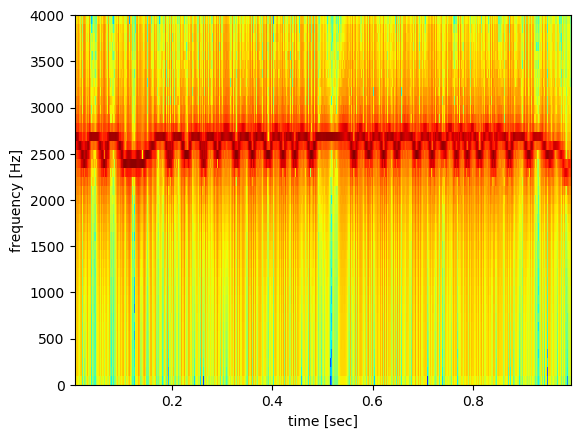

In [12]:
plot_spectrogram(spectrogram(yi, bufsize, bufsize-stepsize, fs=fs), fs)

In [13]:
# generate algorithm
algo = variationalAlgorithm(q)
source_code = compatibility_fix(algorithmSourceCode(algo))
eval(Meta.parse(source_code))
println(source_code)

begin

function stepw!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 2))

messages[1] = ruleVBWishartOut(nothing, ProbabilityDistribution(MatrixVariate, PointMass, m=data[:v_w]), ProbabilityDistribution(ForneyLab.Univariate, PointMass, m=data[:nu_w]))
messages[2] = ruleVariationalARFBIn3PPPN(marginals[:s], marginals[:smin], marginals[:θ], nothing)

marginals[:w] = messages[1].dist * messages[2].dist

return marginals

end

function steps!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 4))

messages[1] = ruleVariationalARFBOutNPPP(nothing, marginals[:smin], marginals[:θ], marginals[:w])
messages[2] = ruleSPMultiplicationOutNGP(nothing, messages[1], Message(MatrixVariate, PointMass, m=data[:c]))
messages[3] = ruleVBGaussianMeanVarianceM(ProbabilityDistribution(ForneyLab.Multivariate, PointMass, m=data[:y]), nothing, ProbabilityDistribution(MatrixVariate, PointMass, m=data[:Σ_x]))
messages[4] = ruleSPMultiplication

In [14]:
function AR_PSD(θ::Array{Float64,1}, ω::Float64, ρ::Float64, σ2::Float64)::Array{Float64,1}
    return σ2 ./ (1 .+ ρ^2 .- 2*ρ*cos.(θ.-ω))
end

function sum_AR_PSD(θ::Array{Float64,1}, ω::Array{Float64,1}, ρ::Array{Float64,1}, σ2::Array{Float64,1})::Array{Float64,1}
    return sum([AR_PSD(θ, ω[m], ρ[m], σ2[m]) for m = 1:length(ω)])
end

sigmoid(x) = 1 ./ (1 .+ exp.(-x))
dsigmoid(x) = sigmoid(x).*(1 .- sigmoid(x))

function logMSE(y::Array{Float64,2}, θ::Array{Float64,1}, ω::Array{Float64,1}, ρ::Array{Float64,1}, σ2::Array{Float64,1})::Float64
    
    # calculate number of AR components
    M = length(ω)
    
    # calculate number of data points
    N = size(y,2)
    
    # calculate MSE
    mse = mean( abs2.(y' .- log.(sum_AR_PSD(θ, ω, ρ, σ2))))
    
    # return MSE
    return mse
    
end

function ∇α_logMSE(y::Array{Float64,2}, θ::Array{Float64,1}, ω::Array{Float64,1}, ρ::Array{Float64,1}, σ2::Array{Float64,1})::Array{Float64}
        
    # calculate number of AR components
    M = length(ω)
    
    # calculate number of data points
    N = size(y,2)
    
    # calculate gradient
    grad = -2 / N * squeeze(sum((y' .- log.(sum_AR_PSD(θ, ω, ρ, σ2))), dims=2))'*(1 ./ sum_AR_PSD(θ, ω, ρ, σ2) .* hcat([AR_PSD(θ, ω[m], ρ[m], σ2[m]) for m=1:length(ω)]...))

    # return gradient
    return squeeze(grad)
end

function ∇β_logMSE(y::Array{Float64,2}, θ::Array{Float64,1}, ω::Array{Float64,1}, ρ::Array{Float64,1}, σ2::Array{Float64,1})::Array{Float64}
        
    # calculate number of AR components
    M = length(ω)
    
    # calculate number of data points\omega[1]
    N = size(y,2)
    
    # calculate gradient
    grad = - 2 / N * squeeze(sum((y' .- log.(sum_AR_PSD(θ, ω, ρ, σ2))), dims=2))'*(1 ./ sum_AR_PSD(θ, ω, ρ, σ2) .* ( σ2 ./ (1 .+ ρ.^2 .- 2*ρ.*cos.(θ'.-ω)).^2)' .* (2*ρ.*sin.(θ'.-ω))' .* (ω.*(1 .- ω/π))')
    
    # return gradient
    return squeeze(grad)
end

function ∇γ_logMSE(y::Array{Float64,2}, θ::Array{Float64,1}, ω::Array{Float64,1}, ρ::Array{Float64,1}, σ2::Array{Float64,1})::Array{Float64}
        
    # calculate number of AR components
    M = length(ω)
    
    # calculate number of data points
    N = size(y,2)
    
    # calculate gradient
    grad =  2 / N * squeeze(sum((y' .- log.(sum_AR_PSD(θ, ω, ρ, σ2))), dims=2))'*(1 ./ sum_AR_PSD(θ, ω, ρ, σ2) .* (σ2 ./ (1 .+ ρ.^2 .- 2*ρ.*cos.(θ'.-ω)).^2)' .* (2*ρ .-2*cos.(θ'.-ω))' .* (ρ .*(1 .- ρ ))')
    
    # return gradient
    return squeeze(grad)
end
function Adam(θ::Array{Float64,1}, ∇::Array{Float64,1}, s::Array{Float64,1}, r::Array{Float64,1}, it::Int64; η=0.001::Float64, ρ1=0.9::Float64, ρ2=0.999::Float64, δ=1e-7::Float64)
    
    # update first moment
    s = ρ1*s + (1-ρ1)*∇
    
    # update second moment
    r = ρ2*r + (1-ρ2)*∇.*∇
    
    # perform bias correction
    sx = s / (1 - ρ1^it)
    rx = r / (1 - ρ2^it)
    
    # update parameters
    θ = θ - η./(δ .+ sqrt.(rx)) .* sx
    
    return θ, s, r
end
;

In [15]:
freqres = 100
smooth = 100
psd = twosided2singlesided(PSDovertime(yi, freqres*2, freqres*2-1, rectangularwindow))[:,:]
log_psd_smooth = vcat([log.(mean(psd[k:k+smooth,:], dims =1)) for k = 1:size(psd,1)-smooth]...)[:,:]
;

In [16]:
L = size(log_psd_smooth, 2) # length of data
M = nr_freqs # nr_clusters
N = size(log_psd_smooth, 1) # data points

# initializers
θ = collect(0:π/L:π - π/L)
ρ = rand(M)/100 .+0.99 # in range 0.9-1.0
σ2 = 10*rand(M)
α = log.(σ2)
ω = collect(π/(M+1):π/(M+1):π-π/(M+1)+0.0001)
β = -log.(π./ω .- 1)
γ = -log.(1 ./ ρ .-1)

# initializers:
s_α = zeros(M)
r_α = zeros(M)
s_β = zeros(M)
r_β = zeros(M)
s_γ = zeros(M)
r_γ = zeros(M)

# optimization
nits = 5000
η1 = 0.001
η2 = 0.00001
η3 = 0.00001

p = Progress(nits)

batches = 50
step = Int(floor(size(log_psd_smooth,1)/batches))

for it = 1:nits
    for b = 1:batches
        α, s_α, r_α = Adam(α, ∇α_logMSE(log_psd_smooth[(b-1)*step+1:b*step, :], θ, ω, ρ, σ2), s_α, r_α, it, η=η1)
        σ2 = exp.(α)
        β, s_β, r_β = Adam(β, ∇β_logMSE(log_psd_smooth[(b-1)*step+1:b*step, :], θ, ω, ρ, σ2), s_β, r_β, it, η=η2)
        ω = π*sigmoid.(β)
        γ, s_γ, r_γ = Adam(γ, ∇γ_logMSE(log_psd_smooth[(b-1)*step+1:b*step, :], θ, ω, ρ, σ2), s_γ, r_γ, it, η=η3)
        ρ = sigmoid(γ)
    end
    η1 = η1*0.99999
    η2 = η2*0.99999
    η3 = η3*0.99999
    mse = logMSE(log_psd_smooth, θ, ω, ρ, σ2)
    ProgressMeter.next!(p; showvalues = [(:it,it), (:mse,mse)])
    #next!(p)
end

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter C:\Users\s151781\.julia\packages\ProgressMeter\lMMY9\src\ProgressMeter.jl:454
Progress: 100%|█████████████████████████████████████████| Time: 0:11:13
  it:   5000
  mse:  0.5127630315216729


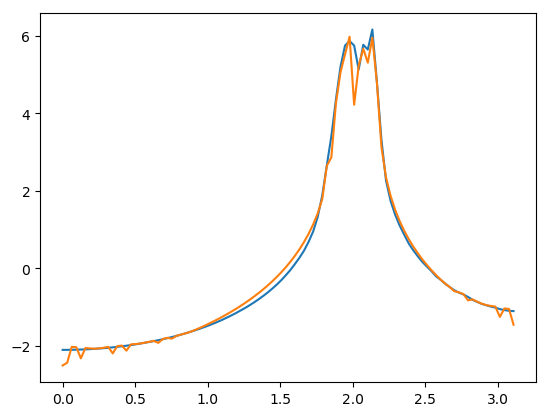

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000000128C6D8>

In [17]:
pred = log.(sum_AR_PSD(θ, ω, ρ, σ2) )
plt.plot(θ, squeeze(mean(log_psd_smooth, dims=1)))
plt.plot(θ, pred)


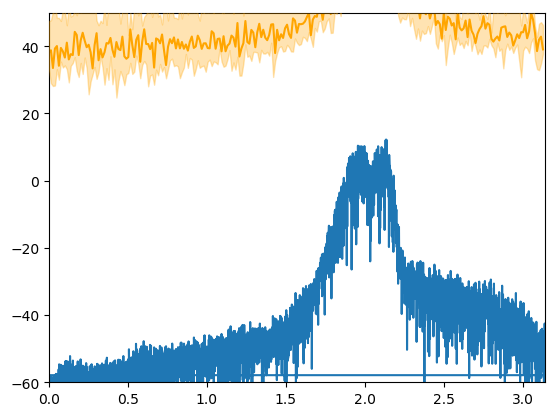

In [18]:
# generation:
Ni = 500 # (nr samples + frequency resolution)
Mi = 10 # nr of iterations

# get parameters ForneyLab.unsafeMean(marginals[:θ])
μ_θi, Σ_θi = repeat(ρ, inner=2), 0.0001*diagm(ones(2*nr_freqs))
v_wi, nu_wi = diagm(1 ./repeat(σ2, inner=2))/(2*nr_freqs), 2*nr_freqs

f = ω/2/π*fs

function generate1psd(μ_θi, Σ_θi, v_wi, nu_wi, N, fs, f)
    # create signal (option 1)
    sif = Array{Float64,2}(undef, 2*length(f), N)
    xif = Array{Float64,1}(undef, N)
    sif[:,1] = zeros(2*length(f))
    xif[1] = 0
    for n = 2:N
        θs = rand(MvNormal(μ_θi, collect(Hermitian(Σ_θi))))
        ws = rand(MvNormal(zeros(2*length(f)), collect(Hermitian(inv(rand(Distributions.Wishart(nu_wi, collect(Hermitian(v_wi)))))))))
        sif[:,n] = θs.*sif[:,n-1] + ws
        xif[n] = collect(sif[:,n]'*reshape( [cos.(2*pi*f/fs*n') sin.(2*pi*f/fs*n')]', 1, 2*length(f))')[1,1]
    end
    return xif
end

function approxpsd(M, μ_θi, Σ_θi, v_wi, nu_wi, N, fs, f)
    psd = Array{Float64,2}(undef, M, N) 
    for m = 1:M
        xif = generate1psd(μ_θi, Σ_θi, v_wi, nu_wi, N, fs, f)
        psd[m,:] = (abs.(FFTW.fft(xif)).^2)./length(xif)
    end
    return squeeze(10*log10.([quantile(psd[:,k], 0.5) for k = 1:N])), squeeze(10*log10.([quantile(psd[:,k], 0.25) for k = 1:N])), squeeze(10*log10.([quantile(psd[:,k], 0.75) for k = 1:N]))
end

mean_psd, std_psd1, std_psd2 = approxpsd(Mi, μ_θi, Σ_θi, v_wi, nu_wi, Ni, fs/stepsize, f)
mean_psd = mean_psd[1:Int(floor(Ni/2))]
std_psd1 = std_psd1[1:Int(floor(Ni/2))]
std_psd2 = std_psd2[1:Int(floor(Ni/2))]
plt.plot(FFTW.fftfreq(length(yi), fs)/fs*2*pi, 10*log10.((abs.(FFTW.fft(yi)).^2)./length(yi)))
plt.plot(abs.(FFTW.fftfreq(Ni, fs)[1:Int(floor(Ni/2))])/fs*2*pi, mean_psd, color="orange")
plt.fill_between(abs.(FFTW.fftfreq(Ni, fs)[1:Int(floor(Ni/2))])/fs*2*pi, std_psd1, std_psd2, color="orange", alpha=0.3, zorder=100)
plt.xlim(0,pi)
plt.ylim(-60,50)
;

In [19]:
duration_train = 1
nr_samples_train = Int((fs*duration_train-bufsize)/stepsize) + 1
signal_t = [yi[(ki-1)*stepsize+1:(ki-1)*stepsize+bufsize].*rectangularwindow(bufsize) for ki = 1:nr_samples_train];
t_t = [t[(ki-1)*stepsize+1:(ki-1)*stepsize+bufsize] for ki = 1:nr_samples_train];
    

In [20]:
N = nr_samples_train
μ_θ_mem = Array{Float64,2}(undef, N, 2*nr_freqs)
Σ_θ_mem = Array{Float64,2}(undef, N, 2*nr_freqs)
μ_s_mem = Array{Float64,2}(undef, N, 2*nr_freqs)
μ_x_mem = Array{Float64,1}(undef, nr_samples_train)
Σ_x_mem = Array{Float64,1}(undef, N)
v_w_mem = Array{Float64,2}(undef, N, 2*nr_freqs)
det_v_w_mem = Array{Float64,1}(undef, N)

# priors
μ_smin = zeros(2*nr_freqs)
Σ_smin = 100*Ic(2*nr_freqs)
μ_θ = repeat(ρ, inner=2)
Σ_θ = 0.001*diagm(ones(2*nr_freqs))
v_w = diagm(1 ./repeat(σ2, inner=2))/(2*nr_freqs)
nu_w = 2*nr_freqs
Σ_x = 1e-1*Ic(bufsize)

p = Progress(nr_samples_train)
marginals = Dict()

for n = 1:nr_samples_train
    
    next!(p)
    
    # fill marginals dictionary
    marginals[:smin] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=μ_smin, v=Σ_smin)
    marginals[:θ] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=μ_θ, v=Σ_θ)
    marginals[:w] = ProbabilityDistribution(ForneyLab.MatrixVariate, ForneyLab.Wishart, v=v_w, nu=nu_w)
    
    # fill data dictionary
    data = Dict()
    data[:μ_smin] = μ_smin
    data[:Σ_smin] = Σ_smin
    data[:μ_θ] = μ_θ
    data[:Σ_θ] = Σ_θ
    data[:v_w] = v_w
    data[:nu_w] = nu_w
    data[:c] = reshape( [cos.(2*pi*f*t_t[n]') sin.(2*pi*f*t_t[n]')]', bufsize, 2*nr_freqs)#cos.(2*pi*f*t[n-bufsize+1:n]')'
    data[:Σ_x] = Σ_x*Ic(bufsize)
    data[:y] = signal_t[n] .- mean(signal_t[n])
    
    # make prediction
    messages = Array{Message}(undef, 4)
    Base.invokelatest(steps!, data, marginals, messages)
    μ_x_mem[n] = ForneyLab.unsafeMean(messages[2].dist)[end] .+ mean(signal_t[n])
    Σ_x_mem[n] = ForneyLab.unsafeCov(messages[2].dist)[end,end]
    
    # perform updates
    for _ in 1:5
        Base.invokelatest(steps!, data, marginals)
        Base.invokelatest(stepθ!, data, marginals)
        Base.invokelatest(stepw!, data, marginals)
        Base.invokelatest(stepsmin!, data, marginals)
    end
    
    # update parameters
    μ_smin = ForneyLab.unsafeMean(marginals[:s])
    Σ_smin = ForneyLab.unsafeCov(marginals[:s])
    μ_θ = ForneyLab.unsafeMean(marginals[:θ])
    Σ_θ = ForneyLab.unsafeCov(marginals[:θ])
    v_w = marginals[:w].params[:v]
    nu_w = marginals[:w].params[:nu]

    # save parameters
    μ_θ_mem[n,:] = μ_θ
    Σ_θ_mem[n,:] = diag(Σ_θ)
    μ_s_mem[n,:] = μ_smin
    v_w_mem[n,:] = diag(v_w)
    det_v_w_mem[n] = det(v_w)
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:26:14m


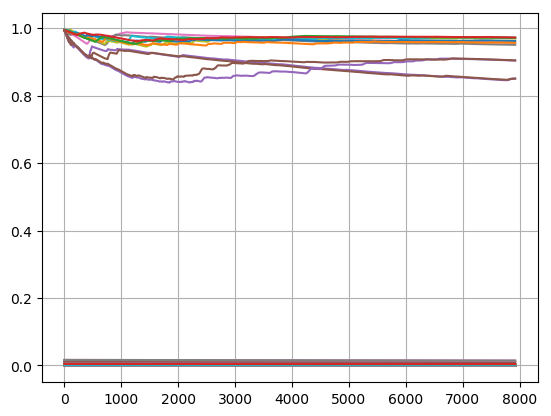

In [21]:
for k = 1:size(μ_θ_mem,2)
    plt.plot(μ_θ_mem[1:nr_samples_train,k])
    #plt.fill_between(t[bufsize:end], μ_θ_mem[1:nr_samples_train,k].+sqrt.(Σ_θ_mem[bufsize:end,k]), μ_θ_mem[bufsize:end,k].-sqrt.(Σ_θ_mem[bufsize:end,k]), alpha=0.3)
end
plt.grid()

In [22]:
y_enhanced = μ_x_mem
y_expected = [signal_t[k][end] for k = 1:nr_samples_train]
;

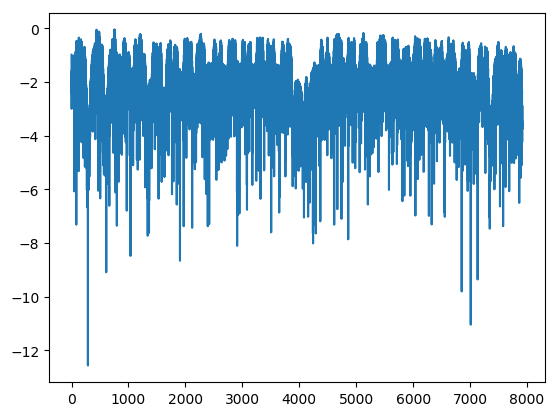

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000003863C0F0>

In [23]:
plt.plot(log.(abs.(y_expected-y_enhanced)))

<source src="data:audio/wav;base64,UklGRkB9AABXQVZFZm10ICgAAAD+/wEAAH0AAAD0AQAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQR9AACyruI9SGD9vqepNz6jYrc+Tx4Tvwzagj6vsJo+WtERv4qglD41a4g+MHgSv6UKrD4qw18+VrQOv8Lztj6l8z8+bfoMv59Cwj6X2yY+1S0Ov9AQ1T7DlwE+8g0Ov5Qo6D5/IKI9UwYGv3NY6j6dPFs9iUsEv9LB9j42DJw8JukBv3JsAz8HAvK8ItP2vsTMBj/qS2m9Sfntvts9Bz98Npa9EXnpvqT5Cj9JicO9dBDpvl+gED/wYgG+D6LavmE0Dj8UEwi+1UbWvrsvDD8yBAi+w6bSvihyDD9g5xW+dxPLvlDTCz+5vRq+kNfNvsJmDz8UzSW+TivMvpC7ET/6DDi+aajJvk1tFj+j7E2+KsbCvoU9Ez94b0a+xc/CvnfDET9dUTm+PJ3Jvm1iFD+s3ka+dWjDvhmiFj/zNFy+0H3Cvra+GT/rYl++u7/EvhuQGD8FaU6+sO3LviJ3GD/9Ij++ANfSvlDjFz/+rzy+AVfQvtOjFj/I7Sy+iKzavjh0Fj/msRW+ovLkvlroFD/P1vK9FRLxvgJmFD9OnbS9Qsj9vh75ED+6rkW98ZwFv+l4Cz/u8Cs8KGkQvwZdCD9j7G49jiIXv1lU/z7MpAM+76kfvymR5z5H8lc+EKgov4jmyz4n8Zk+uvotvy+EpD673sg+vV0vv2DLZj4ReP4+Hjcwv4FP+T2eoBg/Jjwtv0lSPzzTvy4/fCUiv9Du7713tDw/TrkGvwcAj76gsEM/EcK9vt5s7b61Q0c/YfFEvqYJIL+LiTc/Z1wlPXxUQ79/sxQ/dWicPvDfVL+6L7E+yGARP66QSb9lLho9cM5BP3ozHL9bkZe+7BtSP6HnnL7vBxS/8Kg1P3jvjT1RhkK/SCTvPjZ93T4FokO/HhDPPbLKMD9iyBK/RzSdvi4sSz9VZ2++QU4mv1LTLj96HkU+8RRSv6pnuD4Fhxg/VvpGv6DekL2pgVQ/E777vj4wAL+wHlQ/o9pgvQ4YS79b1hY/ZtfFPkqtU78nISI+KcUyP9ljGb8/I5e+1NZDP4oXTL6uKhu/aSIPP6iWez5kgTC/vS8/PghADD9qFQO/h51kvmR/JT+rpie+7J0Pv9R0Bj96GHE+i7kyv2aCbj6Gog8/n3kiv5mXAr7Xqz0/I5bNvkhi677f/zw/2L6pvbUSLb8/vhU/8lpsPkbsQL/qja8+pCL4Pu7jNr8O45U9qYYoP5sJG7+mfjC+q5lAP5vL5r5Bvr6+tHNBP6z/hb7htQa/H5EzP+wpmr1jTyC/DjAcP561tD2zkSy/P3gAP6JHZz7/GTG/QYrJPiZQpj5oHiy/e9qQPhGw0D6lXia/v5FEPs+f7D53YBu/RQ/KPdL2Aj+Y5hK/rvTpPP0rDD9uMQ+/MdYGO8HICj8oJwW/ZuUCvY44Cz+JiwC/wcMrvdx4CT8dpPu+YtsjvTfyBT+5cPi+1gkHvY9gBT+wGAG/YfY+Oy0r+T5c//u+NTmBPB1P9D6zcwK/u6JLPbSm6z40bga/5dOaPa8M6D49gQq/QTXFPS8m4z7VTA2/43oFPvoM0j5ZWAy/z3wjPpHAwD5Nhwu/PyNBPn/Jrz6oVwy/K013PpgSkj5guAm/U/iUPmgAYj7dzgW/K+yrPrG1MT6TCAi/uTTJPqdv/T2pxwi/b1jiPoQbnj2e9we/flz5PuxgXjxcz/m+2Rb5PnCJz7y/guW+IYb4Pg07gr1H+NC+jab5Pkkb4b2DNLm+jBr2PvceCr79tbG+RPcDPwSfXL6XUo6+RqAAP4oxiL53Qk2+RdHyPmqbnL7WAxi+JorxPhDstL5qJNe9hYbzPs9Azb55Ioa9YGT2Ptq14r6+NTO8nmLhPvTf475Pq/Y8HkjSPmxG7r7tebU9MOa6PtQG9b7cnxM+SmipPjcW/L4fyzU+3OCjPjZXBL+gZ2M+zgKUPu7mCb98b44+GnKEPu8QD7/FdaY+8T5lPsODD7+fFbU+0utRPsbMEL8JSr0+OX88PrCqDr+o5so+7FEQPmrrCr9yP9o+dTHFPTvBBb9yNOU+GLxEPWKu974CdOM+HYyVPG705b52zt4+RBuLO0ce475Iee0+PogGvbK85L6AQQE/za6Uvbud3r6CAAU/EKu5vVm83r5skQk/DX7ovSb+1r6Tswk/M8f+vQ6s0b48ygk/VRILvmCpzL6B9As/2XQpvg0fxb7j+Q8/atM3vunLxb7raBI/86U9vtt0x74XwxM/qj9CvhMLx74RqBQ/6GVFvvMnyL7+JxU/9so+vmKQy77qPBQ/+h8qvoAs2b4+UxU/u5cRvpXM5r6CSxQ/1AzbvUmR874XGA8/ZeIxvcFdCL8hLQ4/QKU2PL9lFL+TNg0/vatbPVPhGb+ftAA/0hALPgJqH7+Vudg+sSl7PhS+JL+Xg6Q+LRy/PnJGKb8cxk8+SFIBPyQPK78AhbA9hYgaPw2hHL/xo729RXM2P7wPBr/365K+tjFMP6Zcxr56lfq+EA9MP9r4Fr6ikjO/N8s2P0/eFT6B9VS/yy38PvAN6j6h61S/EO4gPoX6ND/0WCm/sN5pvtaUUz+Adru+jXsOv8VQPj/dMy49D3VCvwc87D68g+U+kWRAvzsNJT0nbjk/9cb+vrHN0b6eKEQ/3eqtvfKQNL+aYgQ/O6rGPogkQL9bjYo9//c2P852Ab/4S8++4TY+PzWjGL2FJTi/5OfnPr+56T7oqDm/taCmvFB1Mz85NcG+fnDrvlfEHD/hJQQ+YRgrvyyeaD4iKQk/NjsEv6rJhL7rpS0/JY8HvgEiIb9Qdwg/QsCjPti1QL99mig++icmPzg6F79xroe+xHBKPxMfl75gGhe/tVY6PxwEYz3STUS/yD0GP6mRuz60SVG/yiuSPhv2FT9e70G/1gojPbyeND+NVB6/WgkzvvwJQT8Y7eq+KeW3vnn/Qj8iqpS+bjQEvw55Pz9MfA++t8Egvw0NNT+Ga0W8ie4vv4seIT/uuuQ9REw5v2W9Dz/qNTo+o5c2v1Pn/D7wsmI+Lk4uv/G43j6zz3M+b2Mmv8qczD60PnQ+5icfv2sIwT6Fnnc+EIQdv47/vT6aoX4+Aa4fv9mxvj6MuHw+1CQdv6YBvT77U3c+CqUfv2PPzT5/CUo+GcoXv81H2D7EOQE+9EQHvyYe1D6A/Lg9dRoBv7Av3z57zzQ9WQL1vol95j52nbg86WD8vumZ/T6eS0W8QAT7vjZVBT+L3Du9P2Lyvs+MBz+tE4y9/mDpvvueCT9nbeu9mBjMvkWOCT+V8jm+Bp+uvkc4DD+mzYC+fSGNvunTDD/n3Zm+2V9/vjPKFD8c8r6+GZM8vuD6ET/lKta+tyQEvvCgDz9PUvC+0l53vYzTBj/B/Pq+h9JLu7ck9D6jgfu+4MlAPfgp3D7vswC/dx3/PVe2tD6lcf6+hbI2Pm0Xnj74uwO/mXd3PiR0hj5BBAe/F4CaPj/hVT4EzQe/HWO3PuCJJD5kxgm/AjHOPoQZ7z1WWwW/sdXUPqaA1j06Fgq/3dLuPrdjUT2TSwa/V/7/Plz9hLspvPi+GmX9Pl2EgbxNx/e+EeQDP/xZSL1NpOm+yE0EP9mkrr0vX9a+XX4EPx65673FO86+JgoJPw4+Eb5Xas6+ziUQPxGaL76/0cy+e6cWP4PPRr7J5su+WCMbPxL7X772pcS+nKIcP3+5dr6FfLq+OKcbP/ylgb4Bs7O+tGQdP0S3j76R8aK+U5UYP7aIlb4KJJa+NI4XP8mvoL7j8Ym+tAMYP2IRsL5meHq+XV0aPzmUwr6KqV++AcwcP5zg0L6FN0u+zJMcP4Vi2L4zdDy+YN4cP859374H+C++rLIbP9He4b7xHC6+6Z0dPwHL576yjR++t+0aP6SF5L7Ct

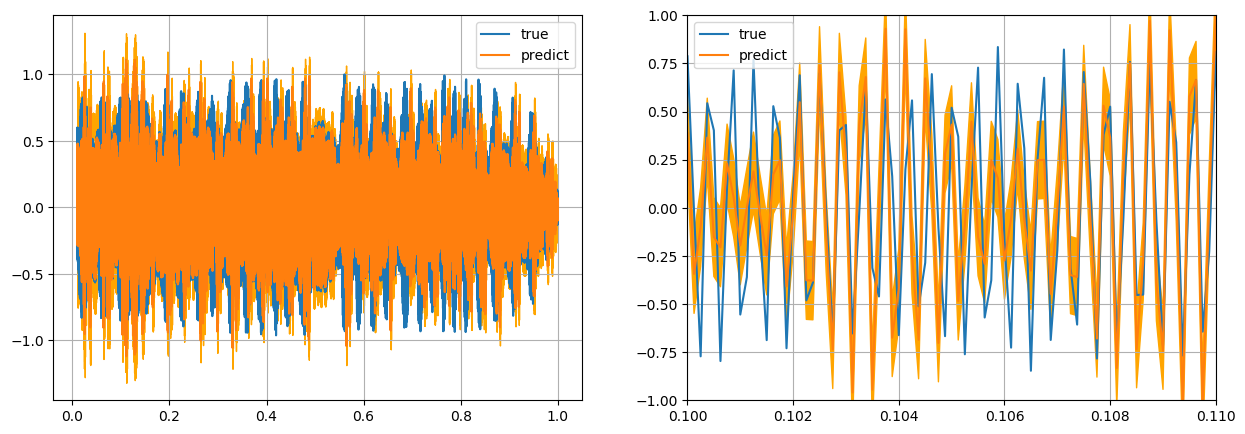

In [24]:
_, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[1].plot(t[bufsize+1:end], y_expected, label="true")
ax[1].plot(t[bufsize+1:end], y_enhanced, label="predict")
ax[1].fill_between(t[bufsize+1:end], μ_x_mem .+ sqrt.(Σ_x_mem), μ_x_mem .- sqrt.(Σ_x_mem), color="orange")
ax[1].grid(), ax[1].legend()
ax[2].plot(t[bufsize+1:end], y_expected, label="true")
ax[2].plot(t[bufsize+1:end], y_enhanced, label="predict")
ax[2].fill_between(t[bufsize+1:end], μ_x_mem .+ sqrt.(Σ_x_mem), μ_x_mem .- sqrt.(Σ_x_mem), color="orange")
ax[2].grid(), ax[2].legend(), ax[2].set_xlim(0.1,0.11), ax[2].set_ylim(-1,1)
audioplayers(yi, y_enhanced, fs=fs*4)

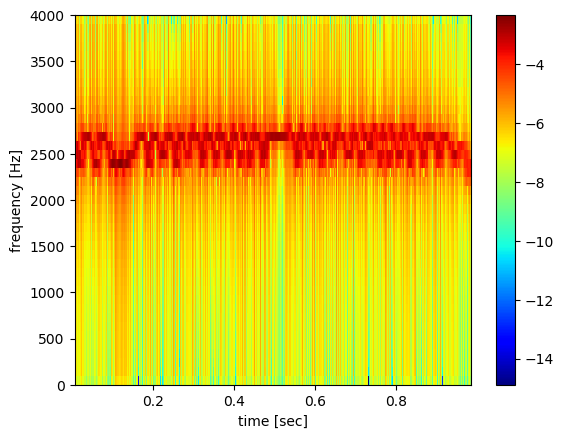

PyObject <matplotlib.colorbar.Colorbar object at 0x00000000026510F0>

In [25]:
plot_spectrogram(spectrogram(y_enhanced, bufsize, bufsize-stepsize, fs=fs), fs)
plt.colorbar()

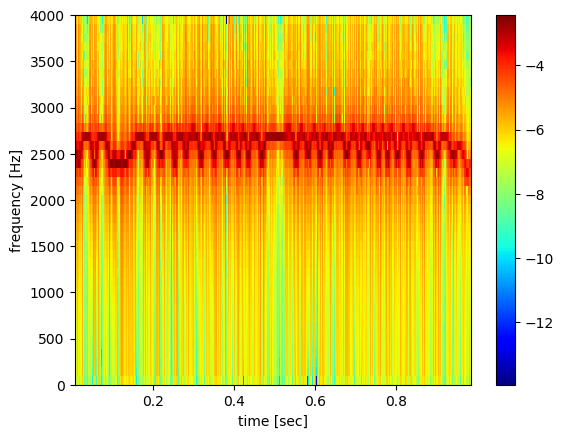

PyObject <matplotlib.colorbar.Colorbar object at 0x0000000038BE8198>

In [26]:
plot_spectrogram(spectrogram(y_expected, bufsize, bufsize-stepsize, fs=fs), fs)
plt.colorbar()

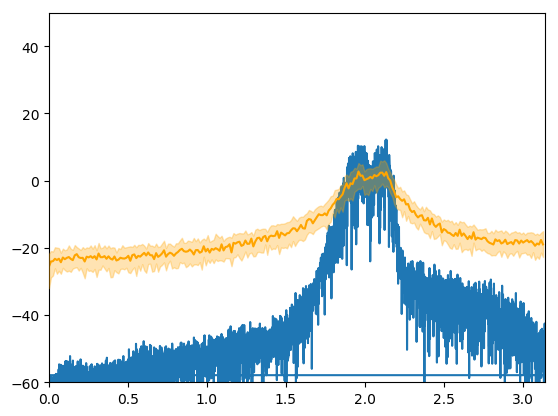

In [27]:
# generation:
Ni = 500 # (nr samples + frequency resolution)
Mi = 100 # nr of iterations

# get parameters ForneyLab.unsafeMean(marginals[:θ])
μ_θi, Σ_θi = ForneyLab.unsafeMean(marginals[:θ]), ForneyLab.unsafeCov(marginals[:θ])
v_wi, nu_wi = marginals[:w].params[:v], marginals[:w].params[:nu]


function generate1psd(μ_θi, Σ_θi, v_wi, nu_wi, N, fs, f)
    # create signal (option 1)
    sif = Array{Float64,2}(undef, 2*length(f), N)
    xif = Array{Float64,1}(undef, N)
    sif[:,1] = zeros(2*length(f))
    xif[1] = 0
    for n = 2:N
        θs = rand(MvNormal(μ_θi, collect(Hermitian(Σ_θi))))
        ws = rand(MvNormal(zeros(2*length(f)), collect(Hermitian(inv(rand(Distributions.Wishart(nu_wi, collect(Hermitian(v_wi)))))))))
        sif[:,n] = θs.*sif[:,n-1] + ws
        xif[n] = collect(sif[:,n]'*reshape( [cos.(2*pi*f/fs*n') sin.(2*pi*f/fs*n')]', 1, 2*length(f))')[1,1]
    end
    return xif
end

function approxpsd(M, μ_θi, Σ_θi, v_wi, nu_wi, N, fs, f)
    psd = Array{Float64,2}(undef, M, N) 
    for m = 1:M
        xif = generate1psd(μ_θi, Σ_θi, v_wi, nu_wi, N, fs, f)
        psd[m,:] = (abs.(FFTW.fft(xif)).^2)./length(xif)
    end
    return squeeze(10*log10.([quantile(psd[:,k], 0.5) for k = 1:N])), squeeze(10*log10.([quantile(psd[:,k], 0.25) for k = 1:N])), squeeze(10*log10.([quantile(psd[:,k], 0.75) for k = 1:N]))
end

mean_psd, std_psd1, std_psd2 = approxpsd(Mi, μ_θi, Σ_θi, v_wi, nu_wi, Ni, fs/stepsize, f)
mean_psd = mean_psd[1:Int(floor(Ni/2))]
std_psd1 = std_psd1[1:Int(floor(Ni/2))]
std_psd2 = std_psd2[1:Int(floor(Ni/2))]
plt.plot(FFTW.fftfreq(length(yi), fs)/fs*2*pi, 10*log10.((abs.(FFTW.fft(yi)).^2)./length(yi)))
plt.plot(abs.(FFTW.fftfreq(Ni, fs)[1:Int(floor(Ni/2))])/fs*2*pi, mean_psd, color="orange")
plt.fill_between(abs.(FFTW.fftfreq(Ni, fs)[1:Int(floor(Ni/2))])/fs*2*pi, std_psd1, std_psd2, color="orange", alpha=0.3, zorder=100)
plt.xlim(0,pi)
plt.ylim(-60,50)
;

In [28]:
x_true = y_expected
x_μ_pred = y_enhanced[1:end]
x_σ_pred = sqrt.(abs.(Σ_x_mem[1:end]));

In [29]:
MSE = mean(abs2.(x_true - x_μ_pred))
MAE = mean(abs.(x_true - x_μ_pred))
BME = mean([logpdf(Normal(x_μ_pred[k], x_σ_pred[k]), x_true[k]) for k = 1:length(x_true)])

MSE, MAE, BME

(0.07697860593945094, 0.2194248611711315, -0.693843536648533)

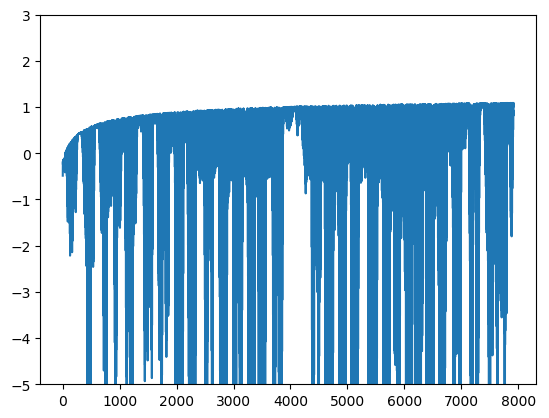

(-5, 3)

In [30]:
plt.plot([logpdf(Normal(x_μ_pred[k], x_σ_pred[k]), x_true[k]) for k = 1:length(x_true)])
plt.ylim(-5,3)